In [1]:
#импортируем нобходимые библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score #метрики классификации
from sklearn.metrics import roc_auc_score # площадь под кривой ошибок

from sklearn.preprocessing import StandardScaler #стандартизатор
from sklearn.model_selection import train_test_split #разбивка на тетовую и валидационную
from sklearn.linear_model import LogisticRegression #логистическая регрессия
from sklearn.ensemble import RandomForestClassifier #случайный лес

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

# Тема: Изучение оттока клиентов фитнес клуба

## Ознакомление с файлом  и EDA

In [2]:
gym = pd.read_csv('/datasets/gym_churn.csv') #прочитаем наш файл
gym.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
gym.columns = gym.columns.str.lower() #приведу для удобства название столбцов к нижнему регистру

In [4]:
gym.info() # посмотрим информацию о файле

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

In [5]:
shape = gym.shape
print(f'Количество строк  - {shape[0]}, количество столбцов  - {shape[1]}')

Количество строк  - 4000, количество столбцов  - 14


In [6]:
duplicated = gym.duplicated().sum() #выведем явные дубликаты для изучения
print('Количество явных дубликатов -', duplicated)

Количество явных дубликатов - 0


Согласно описательной документации датасет имеет следущие поля:

 Набор данных включает следующие поля:
 
*Данные клиента за предыдущий до проверки факта оттока месяц:*
* `gender` — пол;

* `Near_Location ` — проживание или работа в районе, где находится фитнес-центр;

* `Partner ` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);

* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);

* `Phone ` — наличие контактного телефона;

* `Age ` — возраст;

* `Lifetime ` — время с момента первого обращения в фитнес-центр (в месяцах).

*Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:*
* `Contract_period ` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);

* `Month_to_end_contract ` — срок до окончания текущего действующего абонемента (в месяцах);

* `Group_visits ` — факт посещения групповых занятий;

* `Avg_class_frequency_total ` — средняя частота посещений в неделю за все время с начала действия абонемента;

* `Avg_class_frequency_current_month ` — средняя частота посещений в неделю за предыдущий месяц;

* `Avg_additional_charges_total ` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

* `Churn ` — факт оттока в текущем месяце. 
    

###### Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения

In [7]:
gym.isna().sum() #посчитаем количесвто пропусков

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

Отлично, в датасете отсутствуют пропуски.

Теперь посмотрим на средние значения, и стандартные отклонения. Для этого выведим таблицу describe:

In [8]:
gym.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Из таблицы можно сделать следущие выводы можно сказать:

1) По гендерному признаку поситители разбиты практически 50/50. 

2) Большинство клиентов живут или работают в непосредственной близости от фитнес клуба (большое среднее и небольшое стандартное отклонение)

3) Практически половина поситителей фитнес клуба пришли по партнерской программе.

4) Только треть поситителей пришли по промоакции.

5) У абсолютного большинства клиентов указан номер телефона.

6) Абонементы делятся на 3 категории: годовой, полугодовой и месячный. Среднее значение среди клиентов составляет 4.68, стандарное отклонение большое, что говорит нам о большом разбросе предпочтений по длительности абонементов среди клиентов.

7) Менее половины поситителей предпочитают групповые тренировки.

8) Средний возраст клиента составляет 29.2 года.

9) Средняя суммарная выручка от доп. услуг составляет 146.94 у.е., стандартное отклонение значительное, что говорит нам о большом разбросе значений.

10) Средний срок до окончания текущего абонемента 4.32. Стандартное отклонение значительное, что указывает на большой разброс значений данной метрики.

11) Среди клиентов присутствуют люди, которые еще не успели активировать свой абонимент, а так же присутствуют "старожилы" с 31 месяцем стажа. Средний стаж с момента активации абонемента составляет 3.72 месяца. Среднеквадратичное отклонение большое - разброс значений параметров значителен, что логично и неудивительно.

12) В среднем люди проводят 1-2 дня в неделю в спортзале, однако присутствуют люди, которые посещяют его 6 дней в неделю. 

13) Отток клиентов составляет 26,5% процентов.

Посмотрим на стандарнтные отклонения в порядке убывания:

In [9]:
gym.std().sort_values(ascending = False)

avg_additional_charges_total         96.355602
contract_period                       4.549706
month_to_end_contract                 4.191297
lifetime                              3.749267
age                                   3.258367
avg_class_frequency_current_month     1.052906
avg_class_frequency_total             0.972245
gender                                0.499957
partner                               0.499887
group_visits                          0.492301
promo_friends                         0.461932
churn                                 0.441521
near_location                         0.361711
phone                                 0.295313
dtype: float64

###### Среднее значение признаков в двух группах

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [10]:
gym_mean = (gym
            .groupby('churn')
            .agg('mean')
            .transpose() #перевернем
            .rename(columns = {0:'остался', 1:'ушел'}) #переименуем для удобства восприятия
            .round(2)
           )
gym_mean

churn,остался,ушел
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


Глядя на таблицу, можно сразу сказать, что:

1) Отток не связан с половым признаком. Мужчина и женщины уходят одинаково 50/50

2) Люди живущие дальше от фитнес клуба уходят без возврата чаще.

3) Среди ушедших было всего 36% людей, которые пришли по партнерской программе. Среди оставшихся клиентов к парнерской программе относятся 53%.

4) Те, кто приходят по промо за друга остаются чаще.

5) Наличие оставленного контактного номера телефона никак не сказывается на факт оттока. У обеих групп в 90% случаев оставлен контактный номер телефона в базе клуба.

6) Средняя длительность текущего абонемента у группы, которая "сливается" составляет меньше двух месяцев, а именно 1,73. Это может быть связано с тем, что многие брали месячные аббонементы "на пробу", а потом "сливался".

7) В группе людей, которые не ущли в отток, на групповые занятия ходят почти полоивна (46%). Группа, которая ушла в отток проявляла себя в групповых занятиях значительно меньше (27% ушедших клиентов ходило на групповые занятия).

8) Средний возраст оставшихся клиентов 29.98, ушедших - 26.99. Чем старше, тем ответственнее? 

9) Группа, ушедшая в отток, тратила меньше денег на дополнительные услуги.

10) Люди, у которых до окончания абонемента осталось меньше 2-х месяцев чаще уходят в отток. Это может быть связано с тем, что многие брали месячные аббонементы "на пробу".

11) Среднее время с момента первого обращения в фитнес клуб у лояльной группы составляет более 4-х месяцев. У группы, которая уходит в отток, чуть меньше месяца, что подтверждает предположение о том, что среди группы, которая уходит в отток, много абонементов длительностью 1 месяц. 

12) Люди, которые проводят в спортзале стабильно 2 дня в неделю, остаются посетителями клуба. Средняя посещаемость отточной группы составляет менее 1,5 дней.

######  Постройте столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);

In [11]:
binar_list = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits'] #список с бинарными признаками

no_binar_features = gym.drop(binar_list, axis = 1) #небинарные признаки
binar_features = gym.drop(no_binar_features.columns[:7], axis = 1) #бинарные признаки

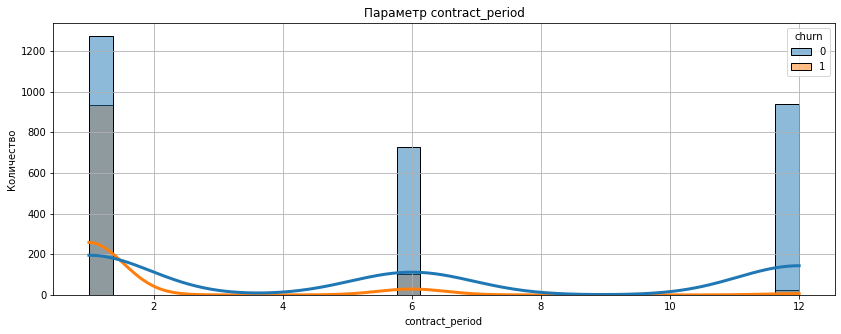

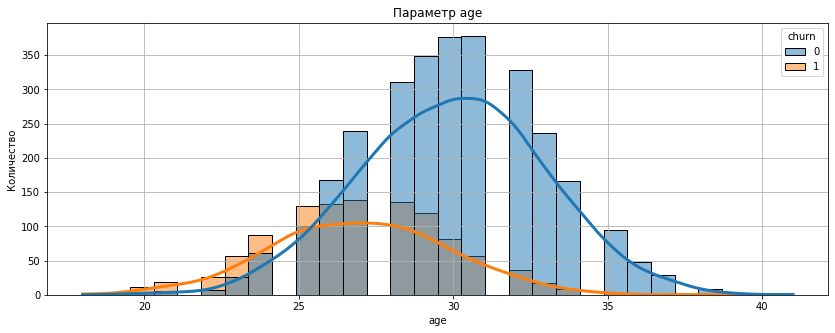

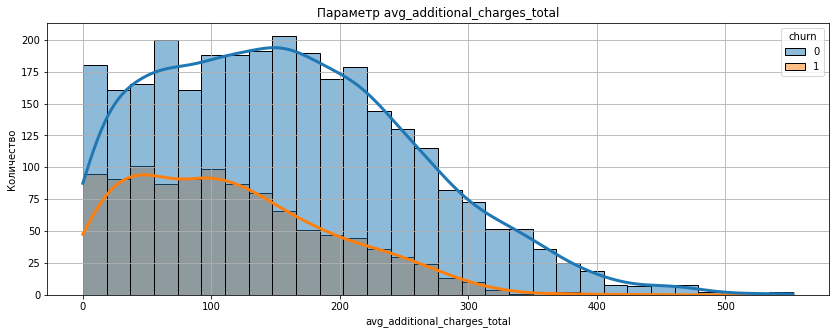

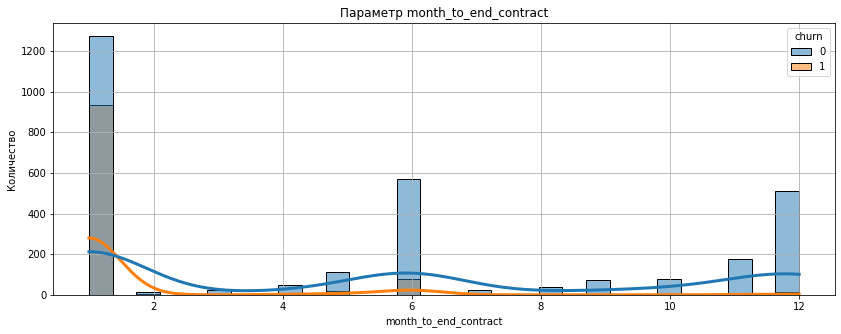

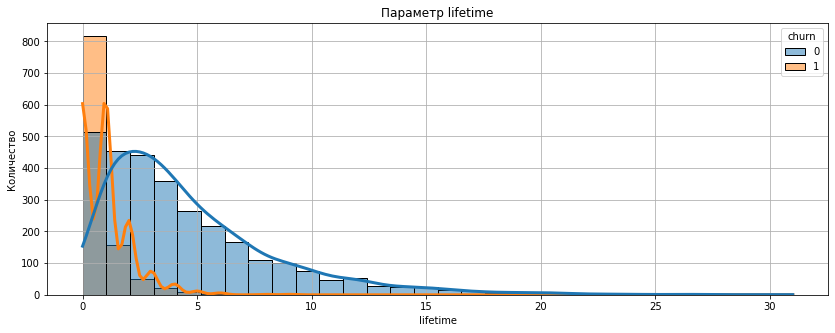

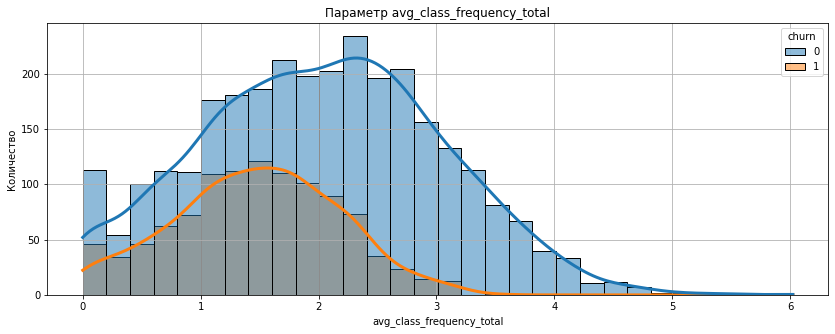

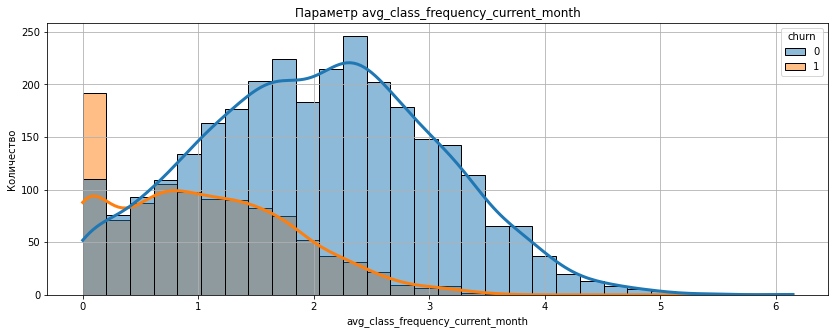

In [12]:

for feature in no_binar_features.drop('churn', axis = 1): #распределения для небинарных признаков
    plt.figure(figsize=(14, 5))
    sns.histplot(data = no_binar_features,
            x = no_binar_features[feature],
            hue = 'churn', 
            kde = True,
            line_kws={"lw":3},
            bins = 30)
    plt.title(f'Параметр {feature}')  
    plt.ylabel('Количество')
    plt.grid()
    plt.show()


После изучения гистограмм приходим к следующим умозаключениям:
 
1) Как и писалось выше, среди "отточников" преобладают абонементы длительностью 1 месяц (934 человека ушло в отток с абонементами в 1 месяц). Чем на больший интералвал времени рассчитан абонемент, тем вероятность оттока меньше (23 человека ушло в отток обладая абонементами рассчитаными на 12 месяцев).
 
2) По параметру "age" гистограмма "отточников" смещена в лево, это нам говорит о том, что прощаются с фитнес клубом молодые люди больше. 
 
3) Клиенты, перешедшие в разряд "отточников" тратили меньше на дополнительные услуги. 
 
4) Чаще всего уходят люди, у которых остается 1 месяц до окончания абонемента. Скорее всего, в эту категорию входят люди, которые доходили свои "большие" абонементы и люди, которые брали маленькие абонементы, как мы предположили выше, "на пробу".
 
5) У "отточников" гистограмма параметра liftime сильно тяготит в левую сторону в связи с большим количеством месячных абонементов. "Отточники" по большей части ходят в зал не более полугода. 
Категория лояльных клиентов в фитнес клуб ходит по большей части до 1,5 лет.
 
6) Клиенты ушедшие из фитнес клуба реже ходят на тренировки.

Рассмотрим бинарные признаки:

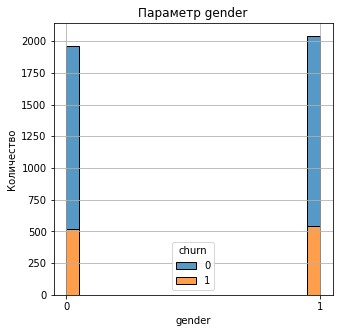

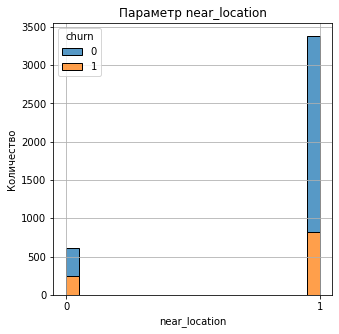

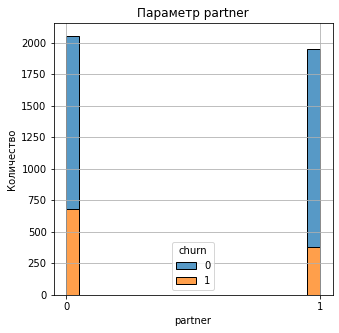

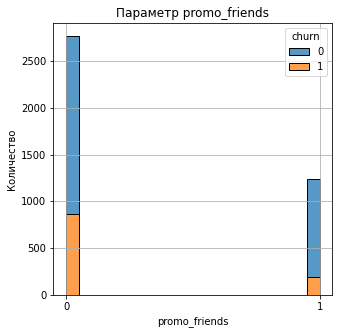

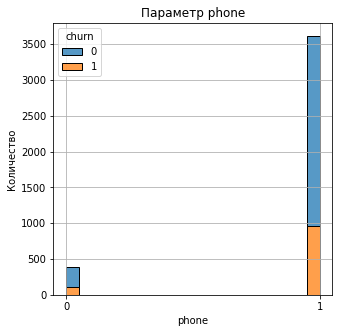

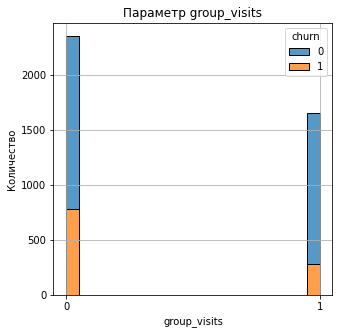

In [13]:
for feature in binar_features.drop('churn', axis = 1): #распределения для бинарных признаков
    
    plt.figure(figsize=(5, 5))
    sns.histplot(data = binar_features,
            x = binar_features[feature],
            hue = 'churn', 
            kde = False,
            multiple="stack", #поставим "накопление" 
            bins = 20)
    plt.title(f'Параметр {feature}')  
    plt.ylabel('Количество')
    plt.xticks([0,1])
    plt.grid()
    plt.show()

1) По параметру гендер отток одинаковый

2) Видим, что люди живущие далеко от фитнес клуба в 40% случаев уходят в отток и только 60% остаются в качестве клиентов.

3) Клиентов, которые не относятся к партнерской программе, немного больше (на 5%) тех, кто находится в системе партнерской программы. Однако, отток среди категории "непартнеров" выше и составляет 33% против 20%. 

4) Людей пришедших по промо акции "друг" - меньше, однако оттока среди них так же меньше. Отток среди группы пришедших по промоакции составляет 15%, в то время как другая группа показывает результат оттока в 31%.

5) Номер контактного телефона записан у большинства посетителей. Если посититель не оставил контактный номер, то отток составляет 27%, если оставил - 26%.

6) Отток среди людей посещающих групповые занятия составляет 17%, та групаа, которая не посещает групповые занятияю уходит в отток в 33% случаев.

######  Изучим матрицу корреляции

<AxesSubplot:>

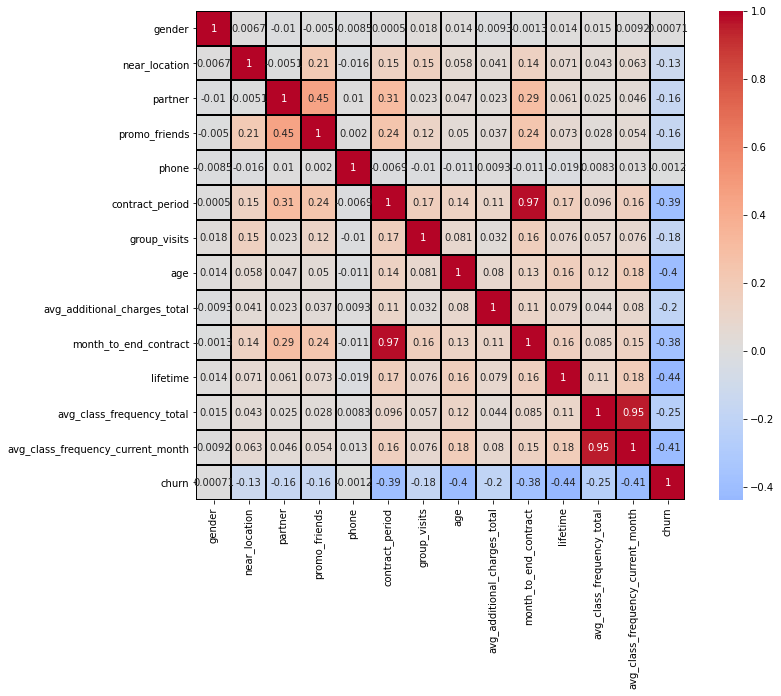

In [14]:
corr_gym = gym.corr() #построим таблицу корреляции

plt.figure(figsize=(12, 9))
sns.heatmap(corr_gym, 
            center= 0, 
            annot = True, 
            square = True, 
            linewidths=1, 
            linecolor='black', 
            cmap= 'coolwarm'
           )

Видно, что присутсвуют мультиколлинеарные параметры: month_to_end_contract сильно коррелируется с contract_period и avg_class_frequency_current_month коррелируется с  avg_class_frequency_total. 

**Выводы**:

1) Отток не связан с половым признаком

2) Люди живущие дальше от фитнес клуба уходят без возврата чаще

3) Клиенты,работающие в команиях-партнерах, более привязаны к фитнес-клубу и уходят реже.

4) Люди пришедшие по промоакции остаются чаще.

5) Наличие оставленного контактного номера телефона никак не сказывается на факт оттока

6) Чем короче абонемент, тем вероятность ухода больше.

7) Клиенты, которые ходят на групповые занятия реже уходят.

8) Средний возраст оставшихся клиентов 29.98, ушедших - 26.99. 

9) Группа, ушедшая в отток, тратила меньше денег на дополнительные услуги.

12) Люди, которые проводят в спортзале стабильно 2 дня и более в неделю, остаются посетителями клуба. Средняя посещаемость отточной группы составляет менее 1,5 дней в неделю.


## Построим модель прогнозирования оттока клиентов

Разбьем данные на обучающую и валидационную выборку функцией train_test_split().

In [15]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
x = gym.drop(['churn'], axis = 1 ) #признаки
y = gym['churn']  #целевая переменная

#разделяем модель на обучающую и валидационную выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

#стандартизируем признаки 
scaler = StandardScaler()  # создаём объект класса scaler

x_train_st = scaler.fit_transform(x_train) #обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

x_test_st = scaler.transform(x_test) #применяем стандартизацию к матрице признаков для тестовой выборки

Обучим модель на train-выборке двумя способами:

 1) логистической регрессией,
 
 2) случайным лесом.

In [16]:
#функция для вывода метрик

def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))
    print('\tROC_AUC: {:.2f}'.format(roc_auc_score(y_true, y_proba)))

In [17]:
#создадим список моделей, фиксируем значение random_state и задаем количество деревьев равных 100
models = [LogisticRegression(random_state = 0), RandomForestClassifier(random_state = 0, n_estimators = 100)]

#напишим функцию, которая будет обучать медели, делать прогнощы и выводить метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(x_train_st, y_train) # обучим модель
    
    predictions = model.predict(x_test_st)
    probabilities = model.predict_proba(x_test_st)[:, 1]
    
    print_all_metrics(
        y_test,
        predictions,
        probabilities,
        title='Метрики:',
)
    
# напишим цикл, который выводит метрики по списку моделей
for i in models:
    print(i)
    make_prediction(
        i,
        x_train_st,
        y_train,
        x_test_st,
        y_test,
    )

LogisticRegression(random_state=0)
Метрики:
	Accuracy: 0.93
	Precision: 0.88
	Recall: 0.87
	F1: 0.88
	ROC_AUC: 0.98
RandomForestClassifier(random_state=0)
Метрики:
	Accuracy: 0.92
	Precision: 0.86
	Recall: 0.83
	F1: 0.84
	ROC_AUC: 0.98


По всем параметрам модель построенная на основе LogisticRegression показала себя лучше.

## Кластеризацию клиентов

In [18]:
# стандартизируем данные
sc = StandardScaler()
x_sc = sc.fit_transform(gym.drop('churn', axis = 1))

Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика предположим, какое количество кластеров можно выделить.

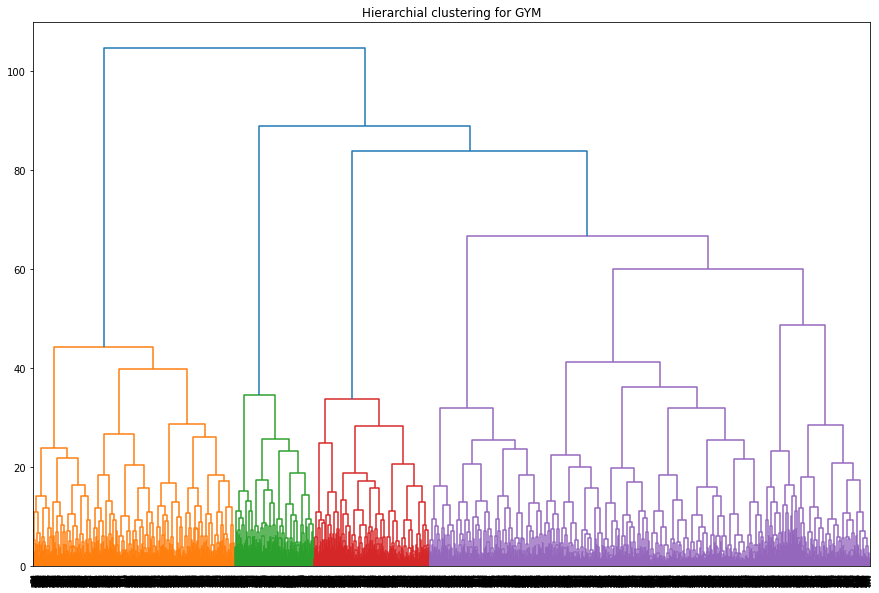

In [19]:
#строим матрцу
linked = linkage(x_sc, method = 'ward') 
#выводим дендограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show() 

Можно выделить от 4 до 6 кластеров.

Обучим модель кластеризации на основании алгоритма K-Means Договоримся за число кластеров принять n=5

In [20]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)

# прогнозируем кластеры для наблюдений 
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
gym_with_cluster = gym
gym_with_cluster['cluster'] = labels #добавим столбец с кластерами

Посмотрим на средние значения признаков для кластеров. Можно ли сразу что-то заметить?

In [21]:
# выводим статистику по средним значениям наших признаков по кластерам
cluster_table = gym_with_cluster.groupby(['cluster']).mean()
cluster_table.transpose()

cluster,0,1,2,3,4
gender,0.502970,0.522078,0.495050,0.485737,0.559666
near_location,0.959406,0.862338,0.000000,1.000000,0.976134
partner,0.783168,0.470130,0.463366,0.350238,0.356802
promo_friends,0.574257,0.306494,0.079208,0.240095,0.230310
phone,1.000000,0.000000,1.000000,1.000000,0.998807
contract_period,10.889109,4.787013,2.352475,1.948494,2.669451
group_visits,0.542574,0.425974,0.215842,0.341521,0.473747
age,29.982178,29.301299,28.477228,28.167987,30.125298
avg_additional_charges_total,160.761016,143.957664,135.457501,131.622204,161.657905
month_to_end_contract,9.954455,4.475325,2.198020,1.856577,2.459427


In [22]:
 gym_with_cluster['cluster'].value_counts() #посмотрми как клиенты распределились по кластерам

3    1262
0    1010
4     838
2     505
1     385
Name: cluster, dtype: int64

Самый многочисленный кластер - 0 (1262 посетителя), самый малочисленый кластер - 1 (385 посетителя).

После деления на кластеры и вывода средних значений парметров, ярко выражены следующие моменты:

1) Кластера почти никак не отличаются по гендерному признаку.

2) Кластер 2 характеризуется тем, что все кто попал в эту группу живут вдали от спортивного зала. Кластер 3 напротив характеризуется близким проживанием или трудоустройством посетителей фитнес-клуба.

3) В кластер 1 попали поситители не оставившие контактный номер телефона.

4) В кластере 0 преобладают люди обладающие годовыми абонементами.

5) Внутри кластера 0 отток людей происходит в  2,7% случаев, в кластере 1 - 26,7% случаев, в кластер 2 - 44,4% случаев, в кластере 3 - 51,4% случаев, в кластере 4 - 6,8% случаев. 

Постройте распределения признаков для кластеров. Можно ли что-то заметить по ним?

In [23]:
binar_list = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits'] #список с бинарными признаками

no_binar_features_with_cluster = gym_with_cluster.drop(binar_list, axis = 1) #небинарные признаки
binar_features_with_cluster = gym_with_cluster.drop(no_binar_features.columns[:7], axis = 1) #бинарные признаки

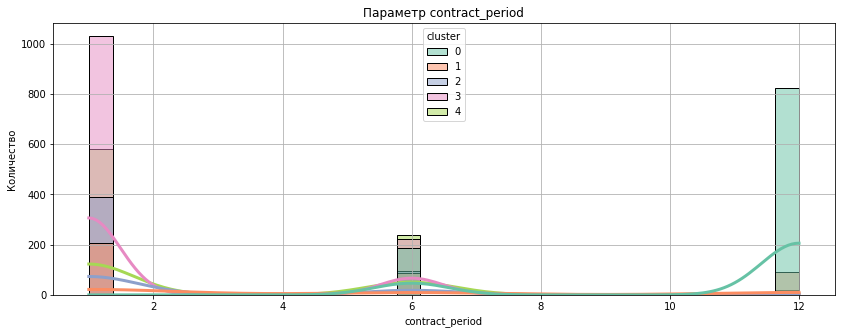

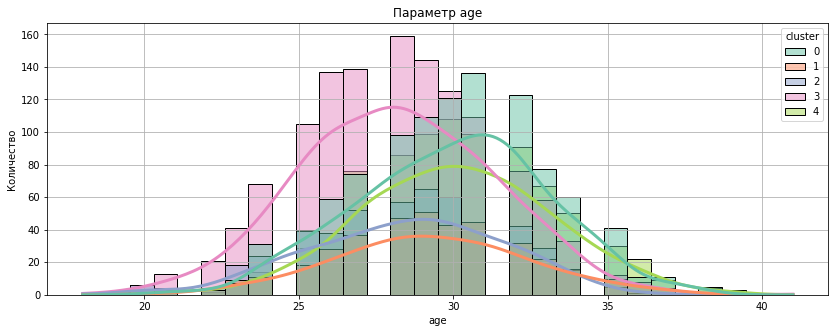

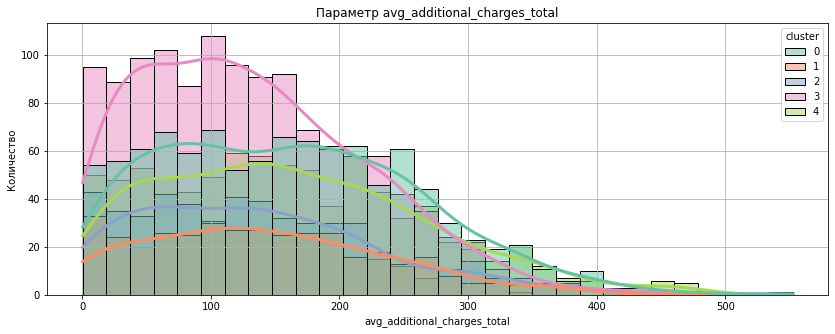

In [ ]:
for feature in no_binar_features.drop('churn', axis = 1): #распределения для небинарных признаков
    plt.figure(figsize=(14, 5))
    sns.histplot(data=no_binar_features_with_cluster,
                x=no_binar_features_with_cluster[feature],
                hue='cluster',
                palette = "Set2",
                kde = True,
                line_kws={"lw":3},
                bins = 30)
    plt.title(f'Параметр {feature}')  
    plt.ylabel('Количество')
    plt.grid()
    plt.show()


На гистограммах можно увидеть следущие моменты:

1) Третий кластер характеризуется большим количеством абонементов с месячным периодом действия.Кластер 0 характеризуется наибольшим количеством абониментов в 12 месяцев.

2) Гистограмма кластера 3 смещена влево, что говорит нам о том, что в этой группе больше людей с меньшим возрастом, чем в других кластерах. А вот кластер 0 наоборот смещен вправо, что означает более возрастных людей.

3) Траты более 400 у.е. во всех кластерах встречаются редко.

4) Так как срок до окончания текущего действующего абонемента ('Month_to_end_contract') сильно коррелируется с  длительностью текущего действующего абонемента 'Contract_period', то распределения практичски идентичны. Третий кластер характеризуется маленькими значениями до 2 меясцев, для кластера 0 характерны, по большей части, значения от 8 до 12 месяцев.

5) На распределении видно, что 3 и 2 кластеры самые "молодые" (гистограммы смещены влево относительно других кластеров), т.е. в 3 и 2 кластеры чаще всего попадают новички фитнес-клуба.

6) Люди попавшие в третий кластер редко посещают зал чаще 2 раз в неделю, люди из 4 кластера более активные и ходят в зал от 1 до 5 раз в неделю. Что примечательно в 4 кластере практически не встречаются люди, которые ходят менее 1 раза в неделю, ято не скажешь об остальных кластерах.

In [ ]:
for feature in binar_features_with_cluster.drop(['cluster'], axis = 1): #распределения для небинарных признаков
    
    plt.figure(figsize=(5, 5))
    sns.histplot(data = binar_features_with_cluster, 
                 x = binar_features_with_cluster[feature], 
                 hue='cluster',
                 palette = "Set2",
                 kde = False,
                 multiple="stack", #поставим "накопление" для лучшей демонстрации отноешения класетров  по параметрам
                 bins = 20)
 
    plt.title(f'Параметр {feature}')  
    plt.ylabel('Количество')
    plt.xticks([0,1])
    plt.grid()
    plt.show()

Для каждого полученного кластера посчитаем долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [ ]:
#посчитаем долю оттока по кластерам
outflow = (gym_with_cluster.query('churn == 1').groupby('cluster')['churn'].count() #сгрупируем ушедших по кластерам
           / #делим
           gym_with_cluster.query('churn==1')['churn'].count() #посчитаем всех ушедших
          ).sort_values(ascending = False)  
outflow

In [ ]:
#выведим пирог для лучшей визуализации
plt.figsize=(20,7)
explode = (0, 0.1, 0.1, 0.1, 0.1)
outflow.plot.pie(autopct = '%1.1f%%', rotatelabels = True, explode = explode, figsize=(18,7))

Больше всего отток поситителей происходит в кластере 3 (61,2% людей уходят), самый лояльный кластер - 0, вероятность того, что человек в этом кластере уйдет в отток составляет 2,6%.

## Выводы

**EDA:**
Был изучен файл, проверены пропуски и типы данных. Значительную предобработку данных делать нет необходимости.

**Кластеризация:**
Были построены модели прогнозирования оттока клиентов сиспользованием моделей "Логистической регрессии" и "Случайного леса". Обе модели показывают отличные результаты, однако наиболее точно по всем параметрам предсказывает LogisticRegression()

**Кластеризация:**

В результате изучения было принято разбить данные на 5 кластеров:

*Кластер 0* - в кластере 0 наименьший отток и составляет всего 2,6%. Клиенты данного кластера характеризуются самыми длительыми абонементами, обычно покупают на 1 год. Так же людей в данном кластере отличает более старший возраст. В средем на доп. услуги тратят 161 у.е., что давольно много, уступают только 4 кластеру по тратам. В среденм посещают зал 2 раза в неделю. Много пришедших по промо.

*Кластер 1* - в данном кластере в отток уходят 9,7% клиентов. Кластер 1 отличает только то, чо он не предоставил свои контактные данные. Больше этот кластер ничего не выделяет.

*Кластер 2* - отток составляет 21,1%. Живут далеко от фитнес клуба. По большей части не ходят на групповые занятия.

*Кластер 3* - кластер с самым большим оттоком (61,2%). В зал ходят меньше всех, примерно 1 раз в неделю. Обладатели самых коротких абонементов, чаще всего на 1 месяц. Самый молодой кластер, в нем больше всего молодежи. Больше всех без парнерской программы. 

*Кластер 4* - отток составляет 5,4%. Ходят на тренировки чаще всех в среднем около 3 дней в неделю. Кто ходил бы меньше 1 дня в неделю не встретишь. Так же как и в кластере 0 здесь собрались люди в районе 30 лет.

**Реккомендации**: 

1) Продавать длительные абонементы

2) Активно пытатьтся внедрять человека в групповые занятия

3) Активно использовать промоакции и партнерские программы

4) Завлекать клиентов в районе 30 лет. Молодежь быстро отваливается.

5) Акцентировать внимание на людей проживающих или работающих в непосредственной близости от клуба.